In [39]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42

In [41]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [42]:
df = pd.read_csv("/jmain02/home/J2AD015/axf03/yxz79-axf03/nlp-prompt-attack/medium-pl-nlp-tutorials/jigsaw-toxic-comment-classification-challenge/train.csv")

In [43]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [44]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
LABEL_COLUMNS = df.columns.tolist()[2:]
LABEL_COLUMNS

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

<AxesSubplot:>

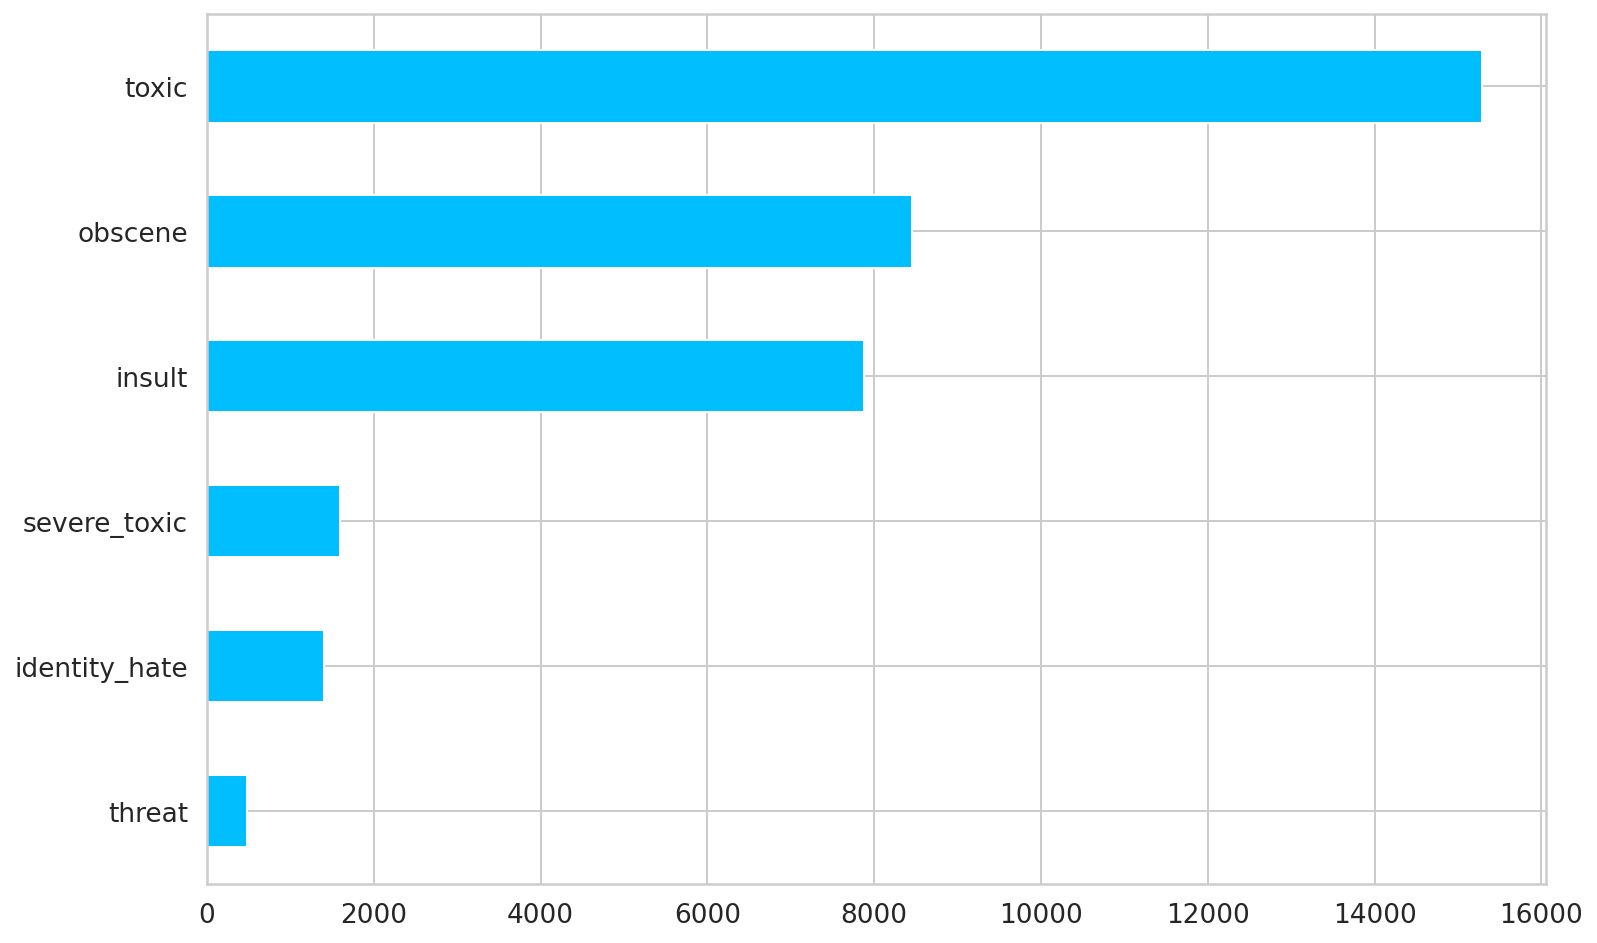

In [46]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind='barh')

In [47]:
df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

<AxesSubplot:>

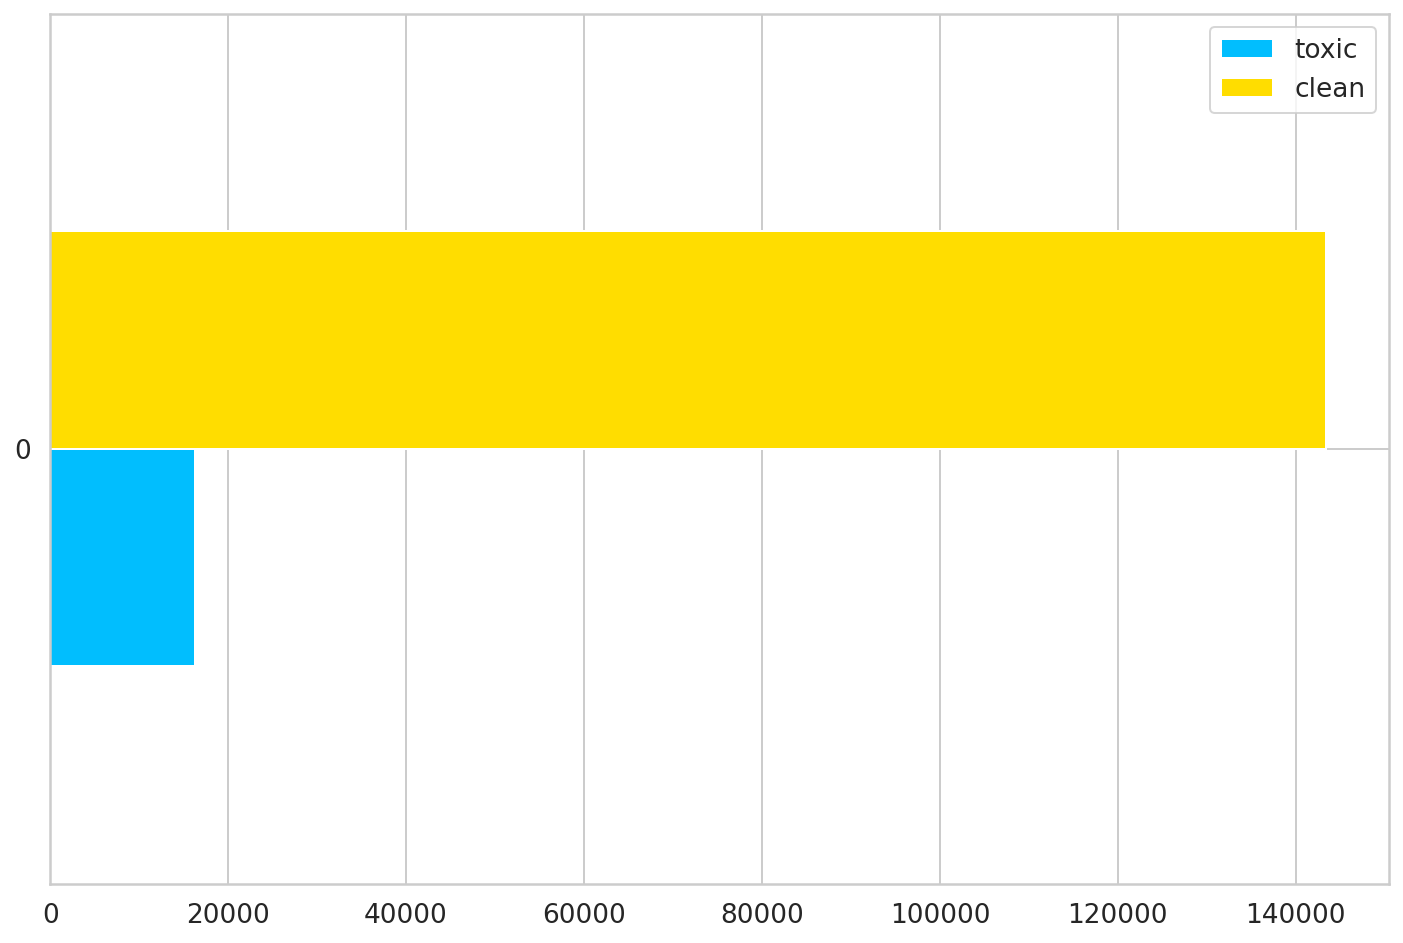

In [48]:
pd.DataFrame(dict(
    toxic=[len(df_toxic)],
    clean=[len(df_clean)]
)).plot(kind='barh')

In [112]:
# an imbalance between toxic comments and clean comments
# recreate a balanced dataset
balance_df = pd.concat([
    df_toxic,
    df_clean.sample(len(df_toxic))
])
balance_df.shape

(32450, 8)

In [50]:
train_df = balance_df.sample(int(len(balance_df) * 0.8), random_state=RANDOM_SEED)
val_df = balance_df.drop(train_df.index)

In [51]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
57737,9a8103881a1d8372,You are an old cougar! You are an old cougar!,1,0,0,0,1,0
53939,90229070532c090f,I completely agree that the dependence on Kins...,0,0,0,0,0,0
83356,df07677ce31a782d,"Okay, so anal sex is as widely unaccepted and ...",1,0,0,0,0,0
34637,5c854590da41ac65,shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,1,0,1,0,1,0
27887,49cfe7691eb59201,You arrogant administrator homosexual bastards...,1,1,1,0,1,1


In [53]:
def isbalanced(df):
    df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
    df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

    pd.DataFrame(dict(
        toxic=[len(df_toxic)],
        clean=[len(df_clean)]
    )).plot(kind='barh')

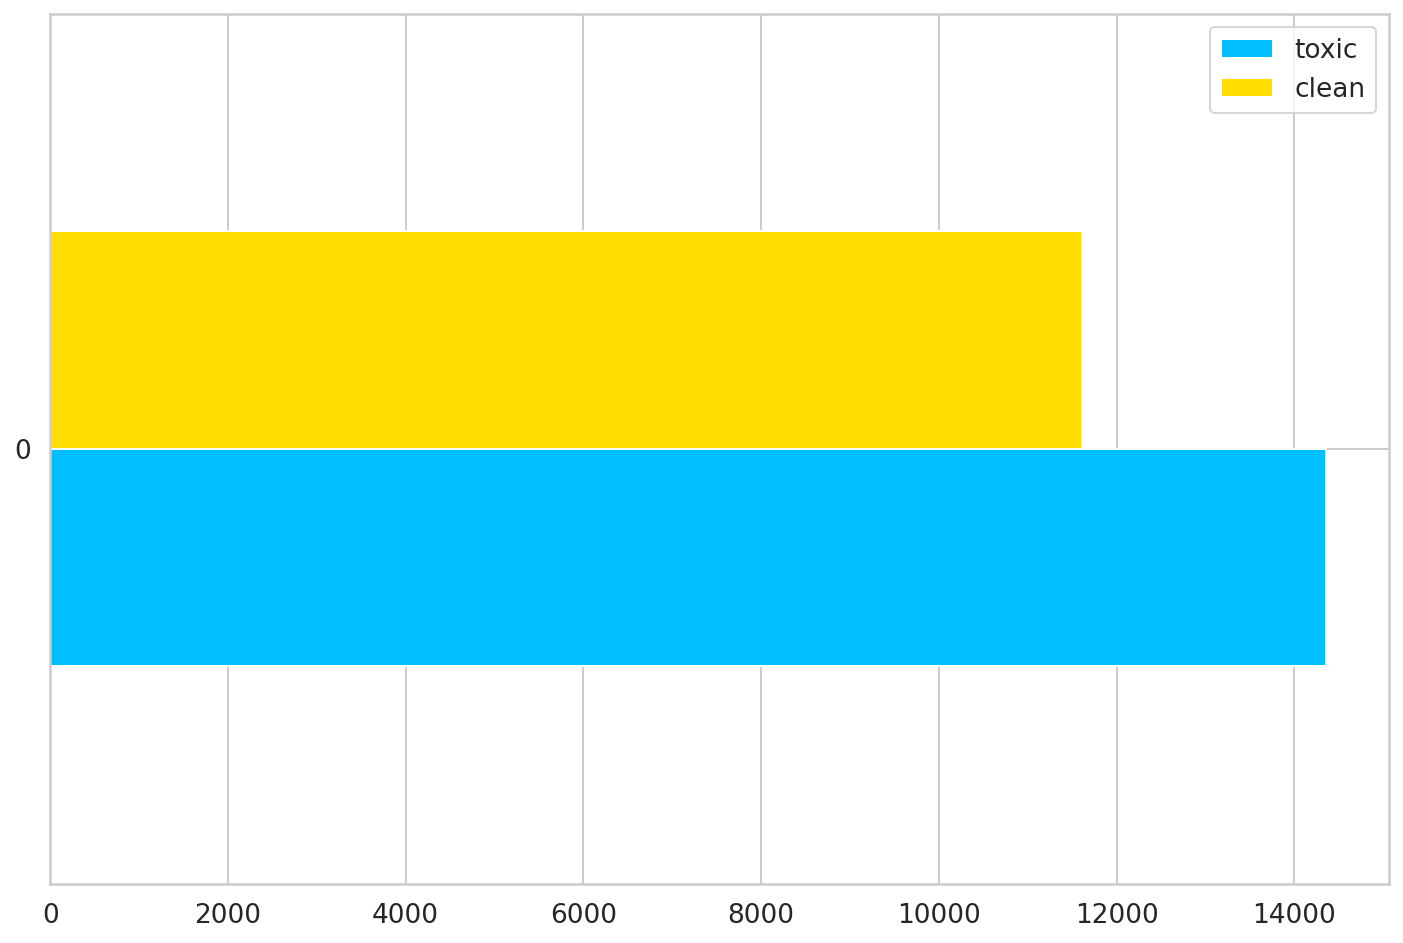

In [54]:
isbalanced(train_df)

In [52]:
val_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0
65,0028d62e8a5629aa,All of my edits are good. Cunts like you who ...,1,0,1,0,1,0
86,0036621e4c7e10b5,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0
159,00637960a7ec3436,"""\n\nUNBLOCK ME OR I'LL GET MY LAWYERS ON TO Y...",1,0,0,0,0,0
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others...",1,0,1,0,1,1


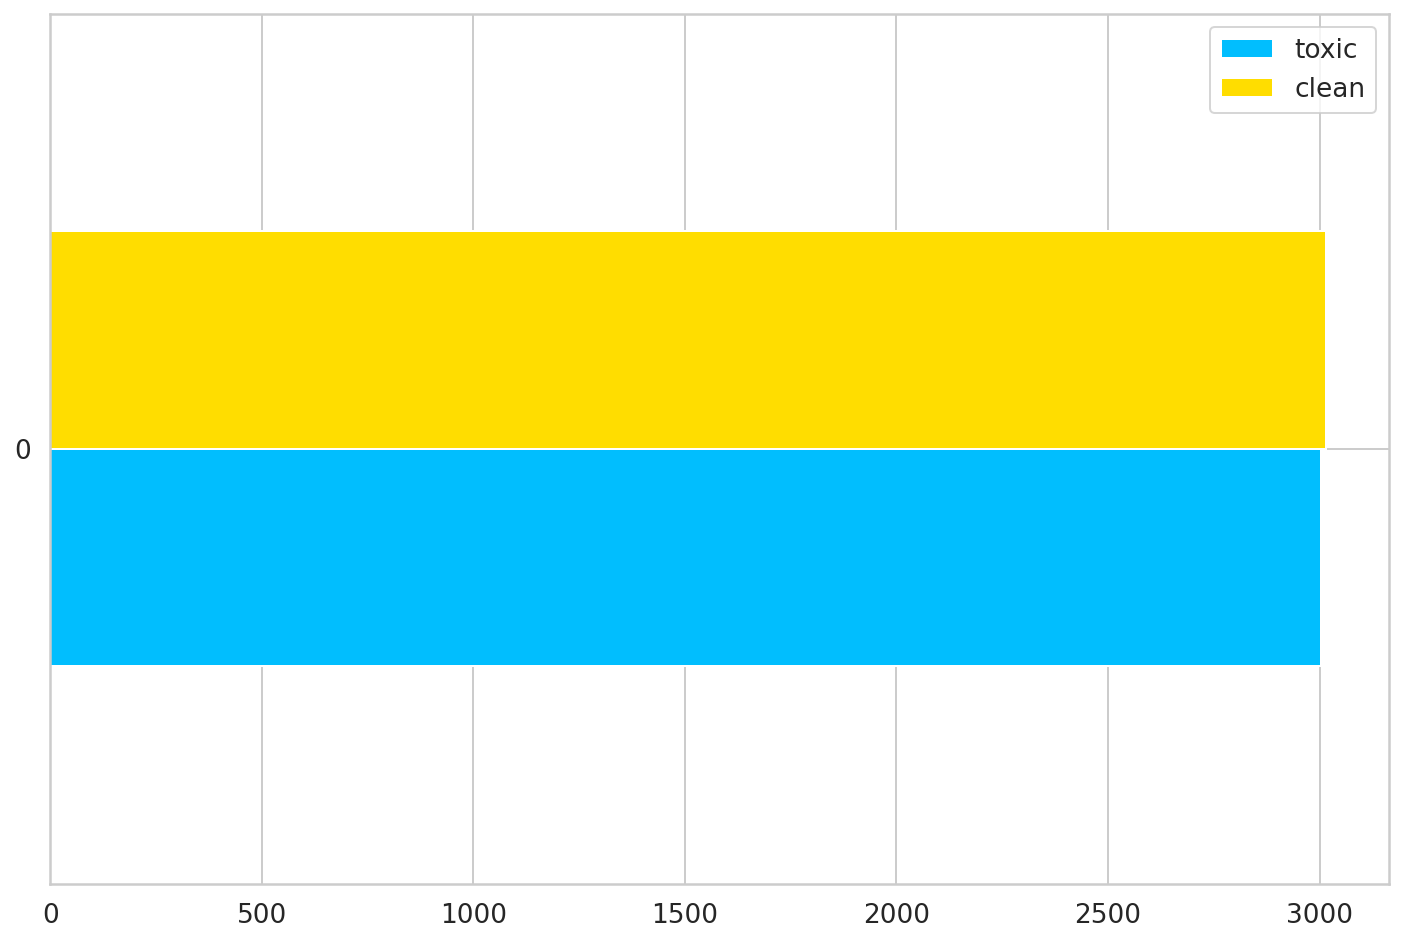

In [55]:
isbalanced(val_df)

In [56]:
df_test = pd.read_csv("/jmain02/home/J2AD015/axf03/yxz79-axf03/nlp-prompt-attack/medium-pl-nlp-tutorials/jigsaw-toxic-comment-classification-challenge/test.csv")

In [58]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [59]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [62]:
sample_row = train_df.iloc[RANDOM_SEED]
sample_comment = sample_row.comment_text
sample_labels = sample_row[LABEL_COLUMNS]
sample_comment, sample_labels

("==This is a DIRECWAY IP.  I hadn't even logged in to Wikipedia back in October.  Perhaps this is a generic IP.",
 toxic            0
 severe_toxic     0
 obscene          0
 threat           0
 insult           0
 identity_hate    0
 Name: 7214, dtype: object)

In [63]:
encoding = tokenizer.encode_plus(
    sample_comment,
    add_special_tokens=True,
    max_length=512,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [64]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [65]:
encoding["input_ids"].squeeze()[:20]

tensor([  101,   134,   134,  1188,  1110,   170,   141, 18172,  8231, 11840,
         3663, 14274,   119,   146,  2018,   112,   189,  1256,  9366,  3660])

In [66]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [67]:
# inverse the tokenizer and get back the words
tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20]

['[CLS]',
 '=',
 '=',
 'This',
 'is',
 'a',
 'D',
 '##IR',
 '##EC',
 '##WA',
 '##Y',
 'IP',
 '.',
 'I',
 'hadn',
 "'",
 't',
 'even',
 'log',
 '##ged']

(0.0, 512.0)

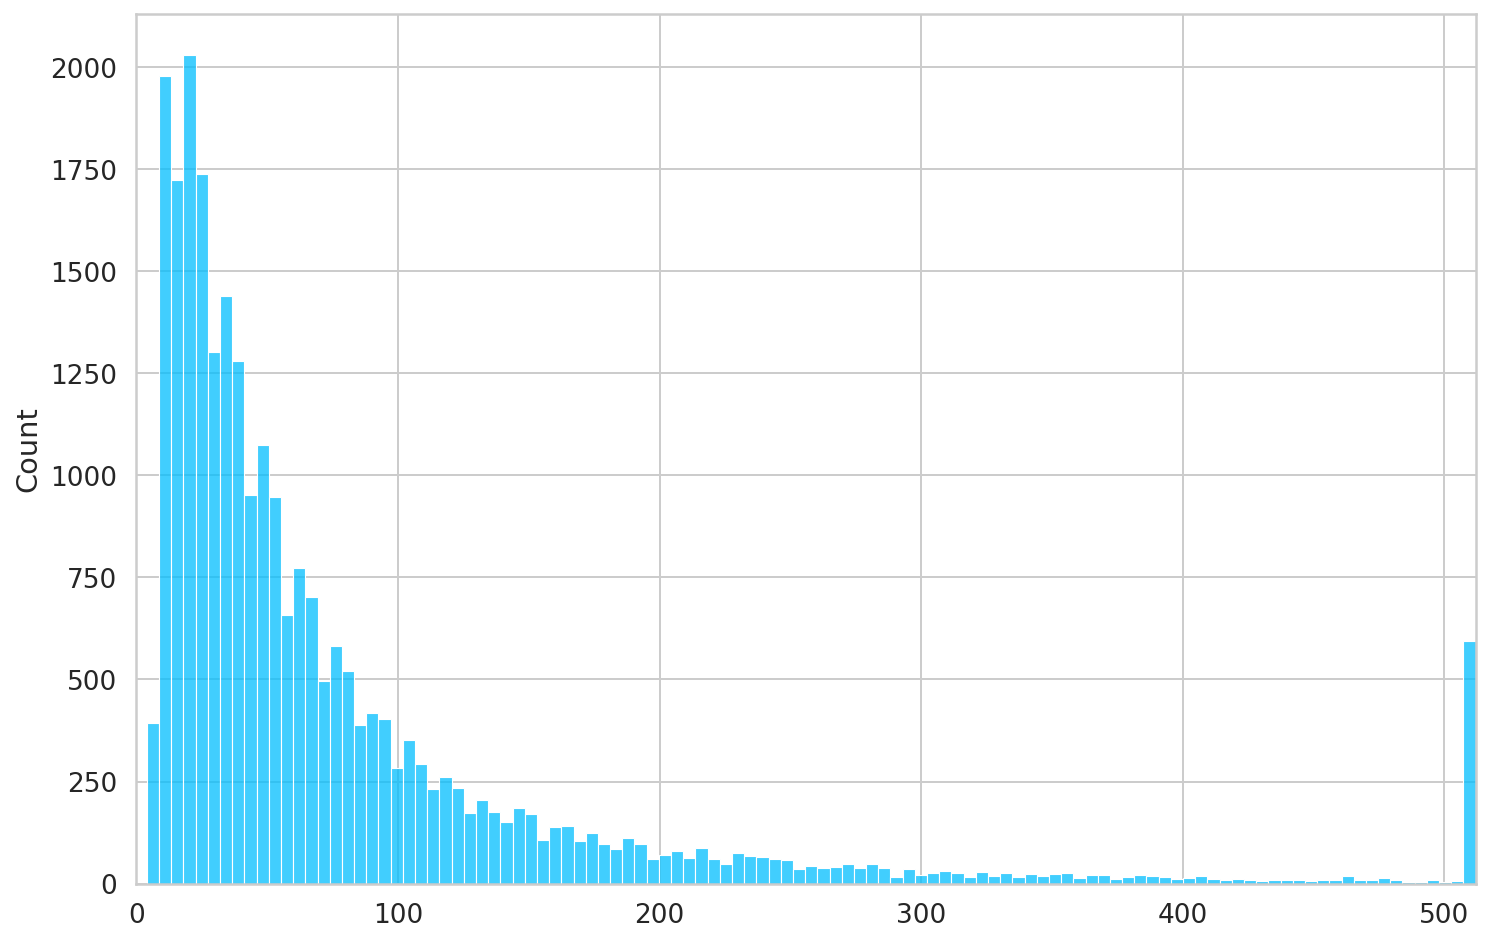

In [68]:
token_counts = []
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
        row["comment_text"],
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0,512])

In [69]:
MAX_TOKEN_COUNT = 512

In [73]:
# an example of pytorch dataset
class ToxicCommentsDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int=128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        comment_text = data_row.comment_text
        labels = data_row[LABEL_COLUMNS]
        encoding = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return dict(
            comment_text=comment_text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [74]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer, MAX_TOKEN_COUNT)

In [75]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [76]:
sample_item["comment_text"]

'You are an old cougar! You are an old cougar!'

In [77]:
sample_item['labels']

tensor([1., 0., 0., 0., 1., 0.])

In [81]:
sample_item['input_ids'][:20]

tensor([  101,  1192,  1132,  1126,  1385,  1884, 15650,  1197,   106,  1192,
         1132,  1126,  1385,  1884, 15650,  1197,   106,   102,     0,     0])

In [82]:
sample_item['attention_mask'][:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [83]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [86]:
train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=2)

In [87]:
sample_batch = next(iter(train_dataloader))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [89]:
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [90]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [91]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [92]:
bert_model.config.hidden_size

768

In [93]:
# wrap custom dataset into a LightningDataModule
class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len
    
    def setup(self, stage=None):
        self.train_dataset = ToxicCommentsDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )
    
        self.test_dataset = ToxicCommentsDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2 # number of processors run in parallel
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset, # because the competition did not provide labels for the test dataset
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

In [94]:
N_EPOCHS = 10
BATCH_SIZE = 12

In [95]:
data_module = ToxicCommentDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [106]:
# model
class ToxicCommentTagger(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self.forward(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self.forward(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self.forward(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
        
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        ) # learning rate scheduler
        
        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

In [101]:
steps_per_epoch = len(train_df) // BATCH_SIZE

In [102]:
total_training_steps = steps_per_epoch * N_EPOCHS

In [103]:
warmup_steps = total_training_steps // 5

In [104]:
warmup_steps, total_training_steps

(4326, 21630)

In [107]:
# create an instance of the model
model = ToxicCommentTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [111]:
""" Training best practices
    - Checkpointing that saves the best model based on validation loss
    - Logging the progress in TensorBoard
    - Early stopping that terminates the training when the loss has not improved for the last 2 epochs
"""
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger('lightning_logs', name='toxic-comments')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

# Trainer instance
trainer = pl.Trainer(
    logger = logger,
    callbacks=[early_stopping_callback,checkpoint_callback],
    max_epochs=N_EPOCHS,
    gpus=1
)

/jmain02/home/J2AD015/axf03/yxz79-axf03/.conda/envs/nlp-prompt-attack-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


MisconfigurationException: CUDAAccelerator can not run on your system since the accelerator is not available. The following accelerator(s) is available and can be passed into `accelerator` argument of `Trainer`: ['cpu'].

In [ ]:
trainer.fit(model, data_module)
trainer.test()

In [ ]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()